In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import plot_model
from keras.callbacks import Callback
from tensorflow.keras.models import load_model
from google.colab import files
from keras.preprocessing import image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/Dataset/Train',
        target_size=(128, 128))

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        '/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/Dataset/Validation',
        target_size=(128, 128))

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/Dataset/Test',
        target_size=(128, 128))

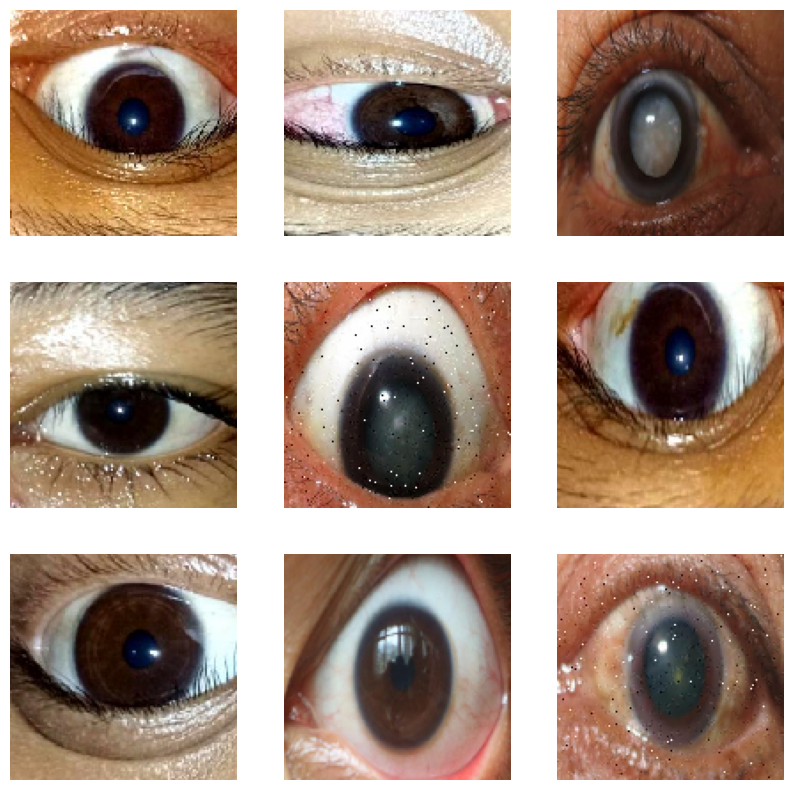

In [ ]:
#Pratinjau Beberapa gambar

for images, labels in train_generator:
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    break
plt.show()

In [ ]:
#Cek Bentuk data
for data_batch, label_batch in train_generator:
    print("Bentuk batch gambar: ", data_batch.shape)
    print("Bentuk batch label: ",label_batch.shape)
    break

Bentuk batch gambar:  (32, 128, 128, 3)
Bentuk batch label:  (32, 3)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Kompilasi

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Latih model

class AccuracyThresholdStopper(tf.keras.callbacks.Callback):
  def __init__(self, accuracy_threshold=0.99):
    super(AccuracyThresholdStopper, self).__init__()
    self.accuracy_threshold = accuracy_threshold

  def on_epoch_end(self, epoch, logs=None):
    val_accuracy = logs.get('val_accuracy')
    if val_accuracy is not None and val_accuracy >= self.accuracy_threshold:
      print(f"\n Akurasi Validasi telah mencapai: {val_accuracy:.4f}, menghentikan pelatihan.")
      self.model.stop_training = True

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
accuracy_stopper = AccuracyThresholdStopper(accuracy_threshold=0.99)

# epochs = 20
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, accuracy_stopper]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5227 - loss: 0.9152 - val_accuracy: 0.9149 - val_loss: 0.1781
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8841 - loss: 0.2865 - val_accuracy: 0.9868 - val_loss: 0.0612
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9434 - loss: 0.1551
 Akurasi Validasi telah mencapai: 0.9905, menghentikan pelatihan.
83/83 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9434 - loss: 0.1552 - val_accuracy: 0.9905 - val_loss: 0.0461


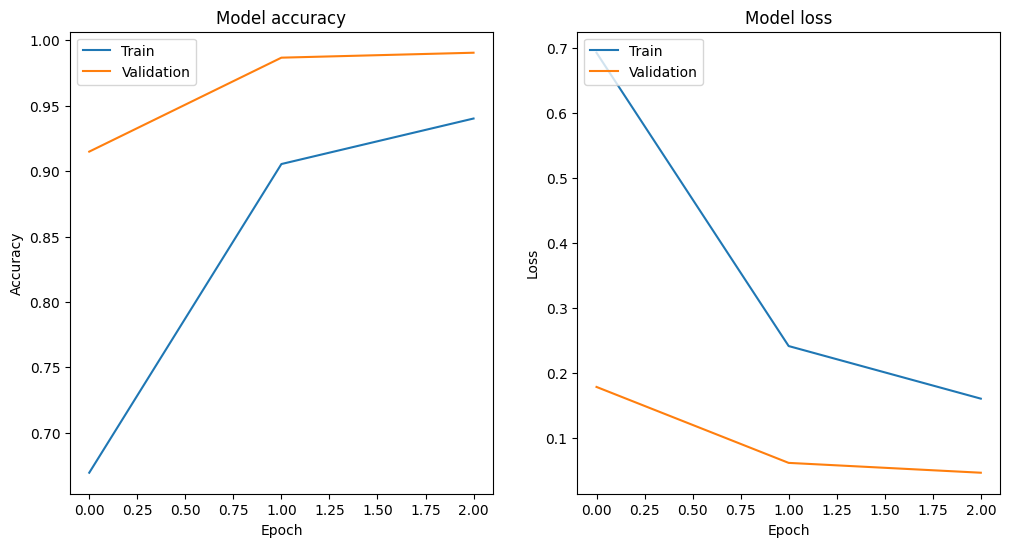

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.summary()

Pilih opsi:
1. Unggah gambar mata
2. Ambil gambar langsung
Masukkan pilihan (1/2): 1


Saving download.jpeg to download (1).jpeg
Memproses file: download (1).jpeg


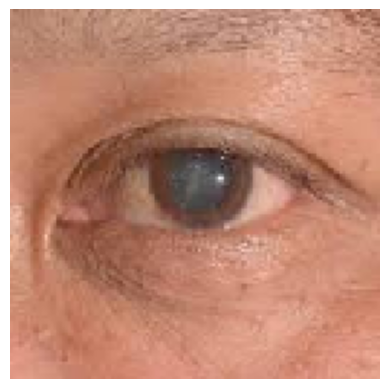

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Lokasi Image: download (1).jpeg
Kondisi Mata: Immature
        Ciri-ciri: Pandangan mulai kabur, sensitivitas terhadap cahaya meningkat, namun belum terlalu mengganggu aktivitas sehari-hari.
        Saran Penanganan:
          1. Segera konsultasikan dengan dokter mata untuk memantau perkembangan.
          2. Hindari paparan cahaya yang berlebihan dan gunakan kacamata pelindung.
          3. Obat tetes mata tertentu (atas rekomendasi dokter) dapat digunakan untuk mengurangi gejala.


In [ ]:
# Fungsi untuk memproses gambar
def process_uploaded_image(image_path, model):
    img = image.load_img(image_path, target_size=(128, 128))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Prediksi
    classes = model.predict(x, batch_size=10)

    # Hasil Prediksi
    print(f"Lokasi Image: {image_path}")
    if classes[0, 0] != 0:
        print('''Kondisi Mata: Immature
        Ciri-ciri: Pandangan mulai kabur, sensitivitas terhadap cahaya meningkat, namun belum terlalu mengganggu aktivitas sehari-hari.
        Saran Penanganan:
          1. Segera konsultasikan dengan dokter mata untuk memantau perkembangan.
          2. Hindari paparan cahaya yang berlebihan dan gunakan kacamata pelindung.
          3. Obat tetes mata tertentu (atas rekomendasi dokter) dapat digunakan untuk mengurangi gejala.''')
    elif classes[0, 1] != 0:
        print('''Kondisi Mata: Mature
        Ciri-ciri: Pandangan sangat kabur, nyaris buta, dan gejala tidak dapat diatasi dengan kacamata.
        Saran Penanganan:
          1. Operasi katarak adalah solusi utama.
          2. Lensa mata yang rusak akan diganti dengan lensa intraokular buatan (IOL).
          3. Operasi ini sangat aman dan memiliki tingkat keberhasilan tinggi.''')
    else:
        print('''Kondisi Mata: Normal
        Ciri-ciri: Mata sehat, tanpa gejala kabur atau buram.
        Saran Penanganan:
          1. Lindungi mata dari sinar UV dengan kacamata hitam.
          2. Konsumsi makanan kaya vitamin A (wortel, bayam).
          3. Rutin periksa kesehatan mata setiap 1-2 tahun.''')

# Input gambar
print("Pilih opsi:")
print("1. Unggah gambar mata")
print("2. Ambil gambar langsung")
choice = input("Masukkan pilihan (1/2): ")

if choice == '1':
    uploaded = files.upload()
    for fn in uploaded.keys():
        # Gunakan file yang diunggah
        print(f"Memproses file: {fn}")
        process_uploaded_image(fn, model)

elif choice == '2':
    from google.colab.output import eval_js
    from base64 import b64decode
    from IPython.display import display, Javascript

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    photo_path = take_photo()
    if photo_path is not None:
        print("Gambar berhasil ditangkap.")
        process_uploaded_image(photo_path, model)
    else:
        print("Gambar tidak dapat ditangkap.")

else:
    print("Pilihan tidak valid. Silakan jalankan ulang program dan pilih 1 atau 2.")


In [ ]:
#Eksport .h5
model.save('/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/OptiLens.h5')

In [ ]:
# Load model dari file HDF5
model = tf.keras.models.load_model('/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/OptiLens.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan file TFLite
tflite_model_path = '/content/drive/MyDrive/Modul/Bangkit/Capstone/OptiLens/Repo-Optilens/OptiLens_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TFLite dan disimpan di: {tflite_model_path}")


Saved artifact at '/tmp/tmpu1sntged'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132441167487120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167481840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167307248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167310768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167665760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167663824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167673856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167674560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167861488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132441167862368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1324411678708